## Finding roots of real functions

### The bisection method

At this point, we've probably seen a *constructive* proof of the intermediate value theorem. An implemenation of that leads to the bisection method!

In [1]:
import numpy as np
def bisection(f,a,b, tolerance = 10**-15, return_cnt = False):
    y1 = f(a)
    if y1 == 0:
        return a
    y2 = f(b)
    if y2 == 0:
        return b
    if np.sign(y1)*np.sign(y2) > 0:
        raise Exception('function has same signs at the endpoints')
    cnt = 0
    while abs(a-b) > a*tolerance and cnt < 100:
        c = (a+b)/2
        y3 = f(c)
        if y3 == 0:
            if return_cnt:
                return c,cnt
            else:
                return c
        if np.sign(y1)*np.sign(y3) < 0:
            b = c
            y2 = y3
        elif np.sign(y2)*np.sign(y3) < 0:
            a = c
            y1 = y3
        cnt = cnt+1
    if return_cnt:
        return c,cnt
    else:
        return c

Here's how to use it to find the solution to $\cos(x) = x$.

In [2]:
def f(x): return np.cos(x) - x
bisection(f,0,1)

0.7390851332151605

The optional `return_cnt` argument allows us to request the number of iterates taken.

In [3]:
bisection(f,0,1, return_cnt = True)

(0.7390851332151605, 51)

And the optional `tolerance` argument allows us to specify the tolerance.

In [4]:
bisection(f,0,1, return_cnt = True, tolerance = 1/8)

(0.6875, 4)

Of course, there's no reason specify a tolerance of less than machine precision.

## Fixed point iteration

Here's another way to solve $\cos(x) = x$.

In [5]:
x1 = 0
x2 = 1
cnt = 0
while np.abs(x1-x2) > 10**(-15) and cnt < 100:
    x1 = x2
    x2 = np.cos(x2)
    cnt = cnt + 1
x2,cnt

(0.73908513321516034, 87)

In [6]:
np.sin(0.739)

0.67354910604856588

I wonder why that takes longer?

## An exploration with fixed point iteration

Suppose we'd like to find the roots of $f(x) = \frac{1}{2}x^5 - 2x - 1$. We might start with a graph.

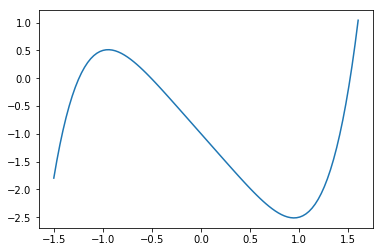

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
def f(x): return x**5/2 - 2*x - 1
x = np.linspace(-1.5,1.6,100)
y = f(x)
plt.plot(x,y)

Looks like we've got three roots. If we want to solve via fixed point iteration, we should rewrite the equation $f(x)=0$ in the form $F(x)=x$ and then iterate $F$. One obvious way to do this is
$$x = \frac{1}{2}\left(\frac{1}{2}x^5-1\right).$$
Thus, we might iterate $F(x) = (x^5/2-1)/2$. Before doing so, let's plot $F$ along with the line $y=x$.

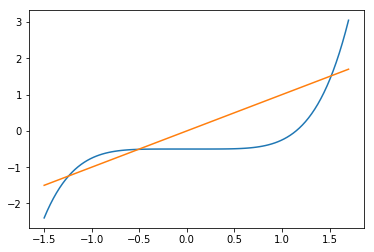

In [8]:
def F(x): return (x**5/2-1)/2
x = np.linspace(-1.5,1.7,100)
y = F(x)
plt.plot(x,y)
plt.plot(x,x)

Looks like we outghtta be able to get the root near $-1/2$ pretty quickly.

In [9]:
x = -0.5
cnt = 0
while np.abs(f(x))>10**-15 and cnt <100:
    x = F(x)
    cnt = cnt+1
x,cnt

(-0.5084994846573327, 13)

At the other roots, though, it appears that $F'$ is larger than one. How might we find those?

Well, there are other $x$s to solve for, if that makes any sense. For example, we might rewrite the equation as

$$x = \sqrt[5]{4x+2}.$$

Note that the weird way of writing this function is necessary since $(-1)^{1/5}$ is a complex number.

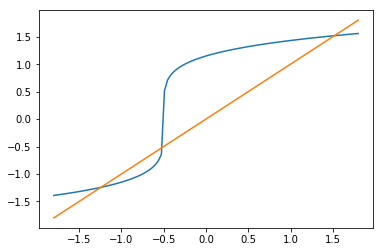

In [10]:
def G(x): return np.sign(4*x+2)*np.abs(4*x+2)**(1/5)
x = np.linspace(-1.8,1.8,100)
y = G(x)
plt.plot(x,y)
plt.plot(x,x)

In [11]:
x = 1.5
cnt = 0
while np.abs(f(x))>10**-15 and cnt <100:
    x = G(x)
    cnt = cnt+1
x,cnt

(1.5185121527849119, 18)

## Newton's method

Newton's method suggests that we iterate
$$N(x) = x - \frac{f(x)}{f'(x)}.$$
For $f(x) = \cos(x)$, we have $f'(x) = -\sin(x)$ so this boils down to 
$$N(x) = x + \frac{\cos(x)}{\sin(x)}.$$
Let's try it!

In [12]:
x = 1
cnt=0
def n(x): return x + np.cos(x)/np.sin(x)
while np.abs(np.cos(x)) > 10**(-15) and cnt < 10:
    x = n(x)
    cnt = cnt+1
x,cnt

(1.5707963267948966, 4)

Wow!

## The secant method

If we can't find the derivative of $f$, we might use the secant method. The idea is to replace $f'(x)$ with it's difference quotient approximation. We then use a two initial seeds and a second order recursion. This leads to the formula
$$x_{n+1} = x_n - f(x_n)\frac{x_n-x_{n-1}}{f(x_n)-f(x_{n-1})}.$$

But you say that you can find the derivative of *any* function - differentiation is *easy* so why in the world would you need the secant method?? Well, in numerical analysis, we often have the function in the form of a [black box](https://en.wikipedia.org/wiki/Black_box); we can use the function to compute output from input but have no other detailed knowledge of it. Here's an example that uses two major ideas we'll explore further in a few weeks: *interpolation* of *data*. We'll have to import a couple of new functions.

In [13]:
from scipy.interpolate import interp1d
from pandas import read_csv

OK, let's import some data and take a look at it.

In [14]:
df = read_csv('https://www.marksmath.org/data/us_population.csv')
df.tail()

year        pop
18  1970  203211926
19  1980  226545805
20  1990  248709873
21  2000  282171957
22  2010  310232863

We've just created a [Data Frame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) by reading a CSV file over the web. There are two columns and we might think of the second column as a function of the first - population of the United States as a function of the year.

Let's plot the data.

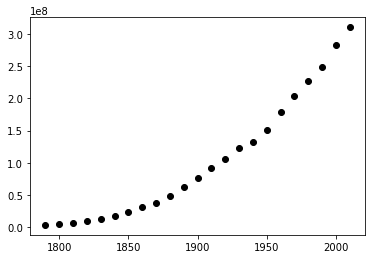

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
x = df.loc[:,'year']
y = df.loc[:,'pop']
plt.plot(x,y,'ok')

Your basic exponential growth with a bloody early to mid $20^{\text{th}}$ century. Note that our population recently passsed $300\,000\,000$. A glance at the data shows that this happened sometime between 2000 and 2010. Suppose we'd like a more precise estimate as to when that happened. Let's interpolate the data to get a smooth function. It's as simple as this:

In [16]:
f = interp1d(x,y)
f(2009.5068)

array(308848899.1160803)

Since `f` is a smooth function, we can apply the secant method:

In [17]:
x1=2000
x2 = 2010
cnt = 0
def F(x): return f(x) - 300000000
while np.abs(x1-x2)>10**(-15) and cnt < 10:
    xtemp = x2
    x2 = x2 - F(x2)*(x2-x1)/(F(x2)-F(x1))
    x1 = xtemp
    cnt = cnt+1
x1,cnt

(2006.3533383419624, 2)

[According to WikiNews](https://en.wikinews.org/wiki/US_population_reaches_300_million), the US population reached 300 million in October of 2006.

## SciPy functions for finding roots

SciPy provides some great [functions for root finding](https://docs.scipy.org/doc/scipy/reference/optimize.html#root-finding) in its optimize module. Here are a few:

In [18]:
from scipy.optimize import bisect, brentq, newton, root

I bet you can guess what `bisect` does. `brentq` is another *bracketed* algorithm (meaning that it searches in an interval) but it uses some ideas similar to Newton's method to accelerate convergence.

In [19]:
brentq(np.cos,0,2)

1.5707963267948966

It's important, though, that the function change sign.

In [20]:
def f(x): return x**2
brentq(f,-1,1)

ValueError: f(a) and f(b) must have different signs

Note that we often use these with so-called *lambda expressions*. These are often known as *pure* or *anonymous* functions in other languages. A lambda expression has the form

    lambda var: f(var)
    
We use this like so:

In [21]:
def f(x): return (x**2-2)**2
def fp(x): return 4*x*(x**2-2)
newton(f,0.1, fp)

1.4142135760510859

In [22]:
newton(lambda x: x**2-2,1)

1.4142135623730947

As we'll see in class, Newton's method does have issues. The `root` command is pretty awesome, though.

In [23]:
root_result = root(lambda x: (x**2-2)**2,1)
root_result

    fjac: array([[-1.]])
     fun: array([  2.41588652e-30])
 message: 'The solution converged.'
    nfev: 72
     qtf: array([ -8.33234331e-30])
       r: array([  1.71752307e-14])
  status: 1
 success: True
       x: array([ 1.41421356])

The `root` function works for vector valued functions and the complicated output makes more sense in that context. We can extract the root easily enough.

In [24]:
root_result['x']

array([ 1.41421356])

### Finding *all* the roots of a complex polynomial

Numpy has a function to compute *all* the roots of a complex polynomial. Here, for example, is how to find all the roots of 
$$f(x)=x^5+2x^4+3x^3+4x^2+5x+6.$$

In [25]:
from numpy import roots
roots([1,2,3,4,5,6])

array([ 0.55168546+1.25334886j,  0.55168546-1.25334886j,
       -1.49179799+0.j        , -0.80578647+1.22290471j,
       -0.80578647-1.22290471j])

This works by setting up the so-called [companion matrix](https://en.wikipedia.org/wiki/Companion_matrix) of the polynomial. This is a matrix whose [characteristic polynomial](https://en.wikipedia.org/wiki/Characteristic_polynomial) is the same as the given polynomial. The roots may then be computed as the eigenvalues of the matrix and, it turns out, that there are powerful methods from linear algebra to do so.

An alternative approach is to use Newton's method with a clever set of starting points. This approach is outlined in a [Math.Stackexchange](https://math.stackexchange.com/questions/998333/finding-the-all-roots-of-a-polynomial-by-using-newton-raphson-method) thread.